# Convolutional Neural Networks (CNN)

## Table of Contents

1. Convolution
    * 1D Convolution
    * Properties
    * 2D Convolution
2. CNN Architecture
3. The Convolution Module
4. Code - CNN for MNIST Classification
5. [Code - CNN for CIFAR-10 Classification](#fourth-bullet2)
6. [Data Augmentation](#fifth-bullet)
7. [Batch Normalization](#sixth-bullet)

# 5. Code - PyTorch CNN for CIFAR-10 Classification  <a class="anchor" id="fourth-bullet2"></a>

* Step 1. Load in the data
  * CIFAR-10: $32 \times 32 \times 3$ color.
  * Labels: automobile, frog, horse, cat, dog, ...
* Step 2. Build the model
* Step 3. Train the model (more: data augmentation)
* Step 4. Evaluate the moel
* Step 5. Make predictions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Download datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [3]:
# Data: Numpy array
display(train_dataset.data[:1])

# Color images with 3 channels
display(train_dataset.data.shape)

# Targets: list
display(train_dataset.targets[:10])

# Number of classes
K = len(set(train_dataset.targets))
print("Number of classes:", K)

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

(50000, 32, 32, 3)

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

Number of classes: 10


In [4]:
# Data loader - automatically generates batches in the training loop and takes care of shuffling
#             - maps the data to (0, 1) and moves the color channel before height/width
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [5]:
# Have a look at the training batches
for x, y in train_loader:
    print(x[0])
    print(x.shape)
    break

tensor([[[0.3333, 0.4000, 0.4353,  ..., 0.6980, 0.7176, 0.5412],
         [0.3255, 0.5020, 0.5725,  ..., 0.5882, 0.5333, 0.4275],
         [0.3255, 0.4941, 0.5137,  ..., 0.4588, 0.4824, 0.3961],
         ...,
         [0.2627, 0.0980, 0.2039,  ..., 0.6157, 0.5529, 0.4863],
         [0.3412, 0.0863, 0.2039,  ..., 0.6235, 0.6588, 0.5373],
         [0.4392, 0.2039, 0.2667,  ..., 0.4745, 0.5412, 0.5098]],

        [[0.5529, 0.5333, 0.5529,  ..., 0.7255, 0.7529, 0.6549],
         [0.5373, 0.6000, 0.6392,  ..., 0.6392, 0.6118, 0.5451],
         [0.5294, 0.6000, 0.6039,  ..., 0.5216, 0.5451, 0.5137],
         ...,
         [0.2078, 0.0314, 0.1490,  ..., 0.7647, 0.7216, 0.6627],
         [0.2863, 0.0314, 0.1490,  ..., 0.7569, 0.8039, 0.6902],
         [0.3843, 0.1529, 0.2118,  ..., 0.6078, 0.6863, 0.6627]],

        [[0.7961, 0.7176, 0.7451,  ..., 0.7765, 0.8039, 0.7765],
         [0.7176, 0.6824, 0.6941,  ..., 0.7137, 0.7020, 0.6745],
         [0.7059, 0.6745, 0.6471,  ..., 0.6039, 0.6275, 0.

In [6]:
# Define the model (without nn.Sequential())
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)

        # Dense layers
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, K)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 3 * 3)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        return x


In [7]:
# Instantiate the model
model = CNN(K)

In [8]:
# Move the model to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
# A function to encapsulate the training loop
def training(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for ep in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
    for inputs, targets in train_loader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) 
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[ep] = train_loss
    test_losses[ep] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {ep+1}/{epochs}:\n \
    Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [11]:
train_losses, test_losses = training(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15:
     Train Loss: 1.6851, Test Loss: 1.4458, Duration: 0:00:42.654787
Epoch 2/15:
     Train Loss: 1.3891, Test Loss: 1.3226, Duration: 0:00:43.291076
Epoch 3/15:
     Train Loss: 1.2723, Test Loss: 1.2242, Duration: 0:00:44.767531
Epoch 4/15:
     Train Loss: 1.1800, Test Loss: 1.1762, Duration: 0:00:44.525583
Epoch 5/15:
     Train Loss: 1.1020, Test Loss: 1.1452, Duration: 0:00:44.473624
Epoch 6/15:
     Train Loss: 1.0432, Test Loss: 1.0942, Duration: 0:00:44.408540
Epoch 7/15:
     Train Loss: 0.9892, Test Loss: 1.0805, Duration: 0:00:44.263446
Epoch 8/15:
     Train Loss: 0.9400, Test Loss: 1.0810, Duration: 0:00:44.721397
Epoch 9/15:
     Train Loss: 0.9003, Test Loss: 1.0244, Duration: 0:00:44.072025
Epoch 10/15:
     Train Loss: 0.8514, Test Loss: 1.0124, Duration: 0:00:44.280967
Epoch 11/15:
     Train Loss: 0.8238, Test Loss: 0.9932, Duration: 0:00:45.990161
Epoch 12/15:
     Train Loss: 0.7858, Test Loss: 1.0043, Duration: 0:00:44.625528
Epoch 13/15:
     Train L

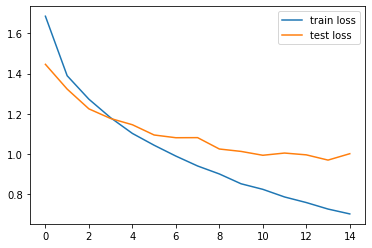

In [12]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [13]:
# Train accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # Move to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


In [14]:
# Print and plot Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(18, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 18)
    plt.yticks(tick_marks, classes, fontsize = 18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black",
               fontsize = 14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.show()

Train acc: 0.7627, Test acc: 0.6636
Confusion matrix, without normalization
[[718  18  51  32  26  13  13  24  68  37]
 [ 23 698   9  23   4   7   9   5  42 180]
 [ 61   2 525 106  98  75  70  37  18   8]
 [ 16   8  62 543  61 150  72  57  12  19]
 [ 17   3  74  92 588  36  90  82   8  10]
 [ 14   3  50 242  48 537  26  63   8   9]
 [  6   2  35 101  28  29 760  19  11   9]
 [ 15   2  30  49  64  69  12 726   6  27]
 [ 76  32  18  27  18  10   9  16 767  27]
 [ 26  60  15  42   9   9  16  23  26 774]]


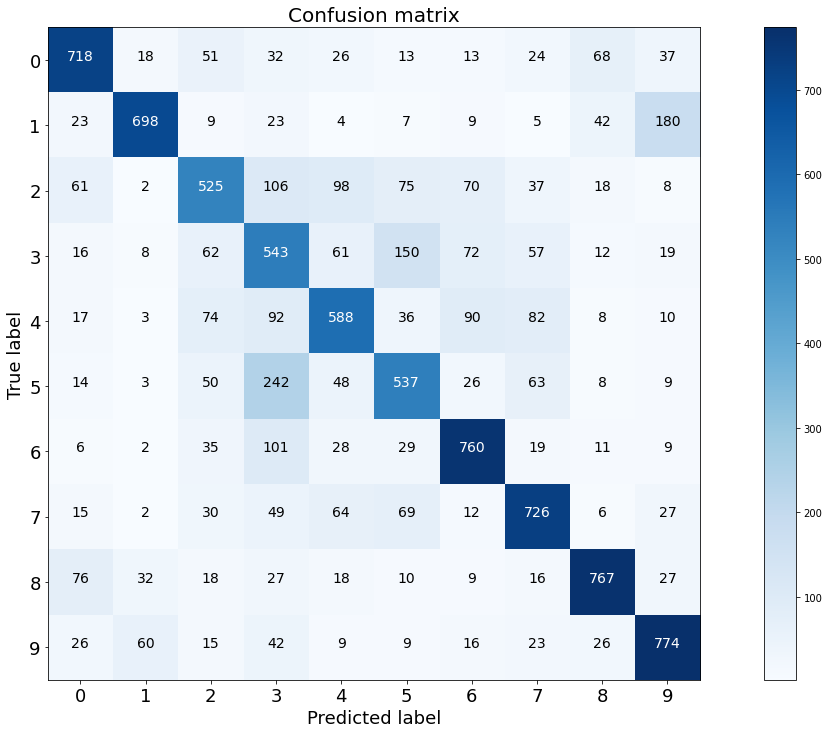

In [15]:
# Test accuracy

model.eval()
n_correct = 0.
n_total = 0.
x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])
for inputs, targets in test_loader:
    # Move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # Update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

    # Update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [16]:
# Label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

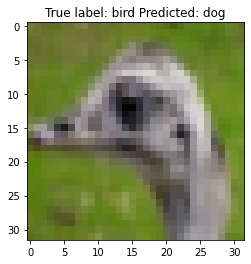

In [17]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32,32,3))
plt.title(f"True label: {labels[y_test[i]]} Predicted: {labels[p_test[i]]}");

# 6. Data Augmentation  <a class="anchor" id="fifth-bullet"></a>

* Use Torch Vision API to rotate images:

  Example: https://pytorch.org/docs/stable/torchvision/transforms.html

  `transform = torchvision.transforms.Compose([
  torchvision.transforms.ColorJitter( brightness=0.2, contrast = 0.2, saturation=0.2, hue=0.2),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  torchvision.transforms.RandomRotation(degrees=15),
  transforms.ToTensor()
])`

  `train_dataset = torchvision.datasets.CIFAR10(
   root='.',
   train=True,
   transform=transform,
   download=True)`
* The data loader does not change. The training loop does not change:

  `train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)`
* Do not augment the test set

# 7. Batch Normalization  <a class="anchor" id="sixth-bullet"></a>

* Steps of batch norm:
  * Batch mean $\mu_B$ and batch std $\sigma_B$ are calculated for each batch.
  * The data are standardized using batch mean and batch std: $z = (x-\mu_B)/\sigma_B$.
  * The data are re-scaled by $\gamma$ and re-located by $\beta$ ($\gamma$ and $\beta$ are learned via the gradient descent): $y = z\gamma + \beta$.

* Batch norm as regularization:
  * Each batch gives different $\mu_B$ and $\sigma_B$. This is essentially noise, and using noise during training makes the neural network impervious to noise.

* Batch norms are more commonly used after convolutional layers.
  * E.g. conv -> BN -> conv -> BN -> conv -> BN -> Flatten -> Dense -> Dense



In [18]:
# Data augmentation
transformer_train = torchvision.transforms.Compose([
  # torchvision.transforms.ColorJitter(
  #     brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  transforms.RandomCrop(32, padding=4),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  # torchvision.transforms.RandomRotation(degrees=15),
  torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
  # torchvision.transforms.RandomPerspective(),
  transforms.ToTensor(),                                            
])

train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transformer_train,
    download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# Data loader
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [20]:
# Make one for testing
train_dataset_fixed = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
train_loader_fixed = torch.utils.data.DataLoader(
    dataset=train_dataset_fixed, 
    batch_size=batch_size, 
    shuffle=False)

Files already downloaded and verified


In [21]:
# Define the model
# 1. No strided convolutions because for small images, normal convolution followed by max pulling seems to work better.
# 2. The idea of multiple convolutions before doing pooling comes from VGG.
# 3. Using padding = 1 to achieve the same size of output image as the input images after convolution. This can be calculated by setting H_in = H_out.
# 4. After each max pool, the size of image is divided by 2. 32 > 16 > 8 > 4


class CNN(nn.Module):
    def __init__(self, K):
    super(CNN, self).__init__()

    # Convolution layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )

    # Dense layers
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, K)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x


In [22]:
# Instantiate the model
model = CNN(K)

In [23]:
# Move the model to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [24]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [25]:
# A function to encapsulate the training loop
def training(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for ep in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) 
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[ep] = train_loss
    test_losses[ep] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {ep+1}/{epochs}: \n \
    Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [28]:
# Training process
train_losses, test_losses = training(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15: 
     Train Loss: 0.3251, Test Loss: 0.4194, Duration: 0:06:16.216503
Epoch 2/15: 
     Train Loss: 0.3154, Test Loss: 0.4129, Duration: 0:06:34.059649
Epoch 3/15: 
     Train Loss: 0.3153, Test Loss: 0.3996, Duration: 0:06:36.238213
Epoch 4/15: 
     Train Loss: 0.3084, Test Loss: 0.4332, Duration: 0:06:42.787999
Epoch 5/15: 
     Train Loss: 0.3059, Test Loss: 0.4297, Duration: 0:06:42.315155
Epoch 6/15: 
     Train Loss: 0.3007, Test Loss: 0.4209, Duration: 0:06:45.882805
Epoch 7/15: 
     Train Loss: 0.2914, Test Loss: 0.4297, Duration: 0:06:45.628378
Epoch 8/15: 
     Train Loss: 0.2896, Test Loss: 0.4423, Duration: 0:06:39.041904
Epoch 9/15: 
     Train Loss: 0.2824, Test Loss: 0.4595, Duration: 0:06:39.718232
Epoch 10/15: 
     Train Loss: 0.2809, Test Loss: 0.4221, Duration: 0:06:41.897310
Epoch 11/15: 
     Train Loss: 0.2753, Test Loss: 0.4074, Duration: 0:06:42.511350
Epoch 12/15: 
     Train Loss: 0.2735, Test Loss: 0.4181, Duration: 0:06:30.791039
Epoch 13/15: 

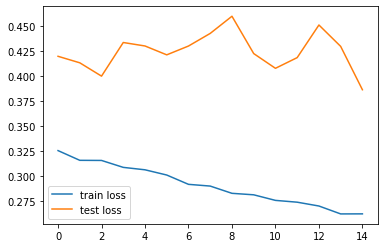

In [29]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [30]:
# Train accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader_fixed:
    # Move to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # Update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}.")

Train acc: 0.9331.


In [32]:
# Print and plot Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(18, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 18)
    plt.yticks(tick_marks, classes, fontsize = 18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black",
               fontsize = 14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.show()

Train acc: 0.9331, Test acc: 0.8762
Confusion matrix, without normalization
[[901   7  23   7   5   2   5   8  31  11]
 [  4 956   0   1   0   0   0   1   5  33]
 [ 27   1 832  26  31  24  38  14   5   2]
 [ 12   4  37 742  25 100  34  26  11   9]
 [  6   2  29  38 860  17  25  20   2   1]
 [  6   0  29  95  13 818  12  25   0   2]
 [  6   2  38  22  11   9 908   1   1   2]
 [ 12   1  14  22  17  19   4 907   2   2]
 [ 39  19   1   4   0   0   4   1 919  13]
 [ 14  41   1   4   0   1   1   2  17 919]]


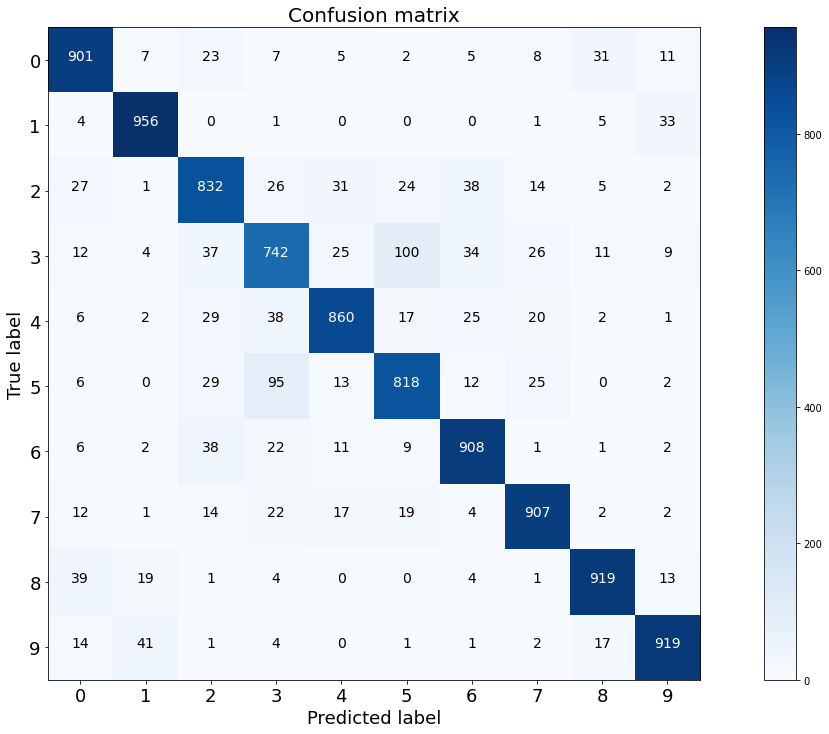

In [34]:
n_correct = 0.
n_total = 0.
x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # Update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

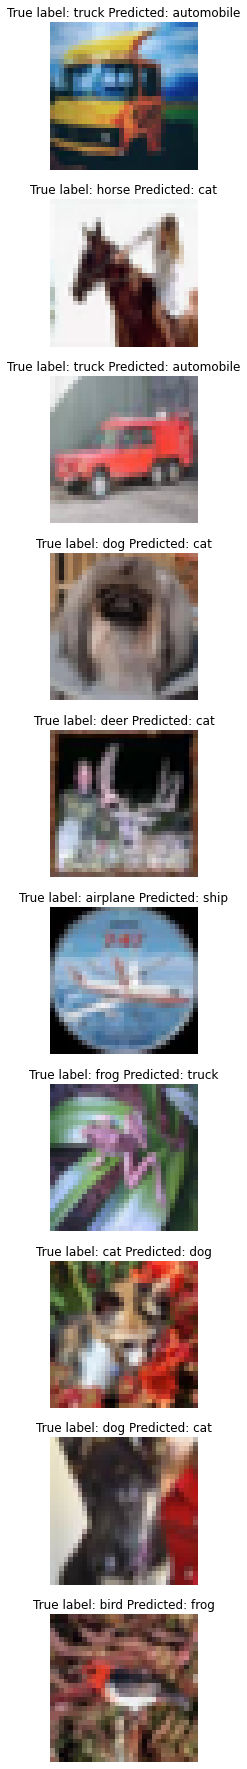

In [35]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassified_idx, 10, replace=False)
plt.figure(figsize=(32,32))
for j, i in enumerate(sample_idx):
    plt.subplot(10, 1, j + 1)
    plt.axis('off')
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

In [36]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6